<a href="https://colab.research.google.com/github/MarielaNina/NeuralNetworksClass/blob/main/Projeto4_Mariela_Nina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO 4 – Redes Neurais Recorrentes para Classificação de Séries Temporais

## Descrição do Projeto

Este projeto implementa um modelo LSTM Bidirecional com mecanismo de atenção para a classificação de séries temporais climáticas, com o objetivo de detectar eventos extremos (ondas de calor, geadas e tempestades) com até 7 dias de antecedência.

## Objetivo

Tarefa escolhida: Classificação de séries temporais.

O modelo recebe uma janela histórica de 30 dias de variáveis climáticas e prevê se haverá ocorrência de um evento extremo nos próximos 7 dias.

## Características Principais

- Arquitetura: LSTM Bidirecional + Mecanismo de Atenção  
- Entrada: janela de 30 dias com 10 variáveis climáticas  
- Saída dupla:  
  - Classificação binária (evento: sim/não)  
  - Regressão da intensidade do evento  
- Comparação entre o modelo com atenção e um modelo baseline com LSTM simples


In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Coleta e Preparação dos Dados

### 1.1 Download de Dados Climáticos Reais

Utilizou-se a API Open-Meteo (gratuita) para obter dados climáticos históricos de São Paulo, Brasil. A API fornece dados diários de temperatura, precipitação, umidade, pressão e velocidade do vento.

**Variáveis climáticas coletadas:**
- Temperatura máxima, mínima e média (°C)
- Precipitação total (mm)
- Velocidade máxima do vento (km/h)
- Umidade relativa média (%)
- Pressão atmosférica média (hPa)

**Período:** 2021-01-01 a 2024-12-31 (4 anos de dados)


In [13]:
def download_weather_data():
    try:
        import requests

        # Coordenadas de São Paulo
        latitude, longitude = -23.5505, -46.6333

        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "start_date": "2021-01-01",
            "end_date": "2024-12-31",
            "daily": [
                "temperature_2m_max",
                "temperature_2m_min",
                "temperature_2m_mean",
                "precipitation_sum",
                "wind_speed_10m_max",
                "relative_humidity_2m_mean",
                "pressure_msl_mean"
            ],
            "timezone": "America/Sao_Paulo"
        }

        response = requests.get(url, params=params, timeout=30)

        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame({
                'date': pd.to_datetime(data['daily']['time']),
                'temp_max': data['daily']['temperature_2m_max'],
                'temp_min': data['daily']['temperature_2m_min'],
                'temp_mean': data['daily']['temperature_2m_mean'],
                'precipitation': data['daily']['precipitation_sum'],
                'wind_speed': data['daily']['wind_speed_10m_max'],
                'humidity': data['daily']['relative_humidity_2m_mean'],
                'pressure': data['daily']['pressure_msl_mean']
            })
            print(f"Dados reais baixados: {len(df)} dias")
            return df

    except Exception as e:
        print(f" Erro ao baixar dados: {e}")

    # Geração de dados sintéticos com padrões realistas
    dates = pd.date_range(start='2021-01-01', end='2024-12-31', freq='D')
    n = len(dates)

    # Temperatura com sazonalidade
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    seasonal = 25 + 8 * np.sin(2 * np.pi * day_of_year / 365 - np.pi/2)
    trend = np.linspace(0, 2, n)
    noise = np.random.normal(0, 3, n)
    temp_mean = seasonal + trend + noise

    temp_max = temp_mean + np.random.uniform(3, 8, n)
    temp_min = temp_mean - np.random.uniform(3, 8, n)

    # Precipitação com eventos extremos
    precip_base = np.abs(np.random.gamma(2, 2, n))
    extreme_rain_days = np.random.choice(n, size=int(n*0.05), replace=False)
    precip_base[extreme_rain_days] += np.random.uniform(50, 150, len(extreme_rain_days))

    wind_speed = np.abs(np.random.gamma(3, 2, n))
    humidity = 50 + 30 * np.sin(2 * np.pi * day_of_year / 365) + np.random.normal(0, 10, n)
    humidity = np.clip(humidity, 20, 100)
    pressure = 1013 + np.random.normal(0, 10, n)

    df = pd.DataFrame({
        'date': dates,
        'temp_max': temp_max,
        'temp_min': temp_min,
        'temp_mean': temp_mean,
        'precipitation': precip_base,
        'wind_speed': wind_speed,
        'humidity': humidity,
        'pressure': pressure
    })
    return df

# Executar download
df_raw = download_weather_data()

# Visualizar primeiras linhas
print("\n Amostra dos dados:")
print(df_raw.head(10))

print("\n Estatísticas descritivas:")
print(df_raw.describe())


Dados reais baixados: 1461 dias

 Amostra dos dados:
        date  temp_max  temp_min  temp_mean  precipitation  wind_speed  \
0 2021-01-01      26.1      18.6       21.3            9.9        20.8   
1 2021-01-02      23.4      18.6       20.2            4.3        22.7   
2 2021-01-03      24.5      17.0       19.5            3.5        27.0   
3 2021-01-04      26.3      17.2       20.6            5.9        17.4   
4 2021-01-05      28.5      17.6       22.8            8.7        12.0   
5 2021-01-06      29.5      20.7       24.2            4.6        20.4   
6 2021-01-07      28.8      20.9       24.0            7.6        23.8   
7 2021-01-08      26.5      20.6       22.7           10.9        18.9   
8 2021-01-09      26.8      19.6       22.2            1.3        23.7   
9 2021-01-10      27.4      19.7       22.7            8.4        20.8   

   humidity  pressure  
0        84    1014.8  
1        88    1014.9  
2        86    1014.2  
3        84    1013.9  
4        81 

## 2. Detecção de Eventos Climáticos Extremos

### 2.1 Definição de Eventos Extremos

Os eventos climáticos extremos são definidos com base em percentis e limiares físicos:

1. Onda de calor: temperatura máxima > P95 por 3 ou mais dias consecutivos
2. Geada: temperatura mínima < 2°C
3. Tempestade: precipitação > P95

### 2.2 Classificação Binária

**Variável target:** `extreme_event`  
0 = normal  
1 = evento extremo

Esta é a tarefa de classificação de série temporal que o modelo irá aprender.



  Limites de eventos extremos:
  • Onda de calor: Temperatura > 31.3°C por 3+ dias
  • Geada: Temperatura < 2°C
  • Tempestade: Precipitação > 17.1mm

nEventos detectados:
  • Ondas de calor: 43 dias (2.9%)
  • Geadas: 0 dias (0.0%)
  • Tempestades: 73 dias (5.0%)
  • TOTAL eventos extremos: 116 dias (7.9%)


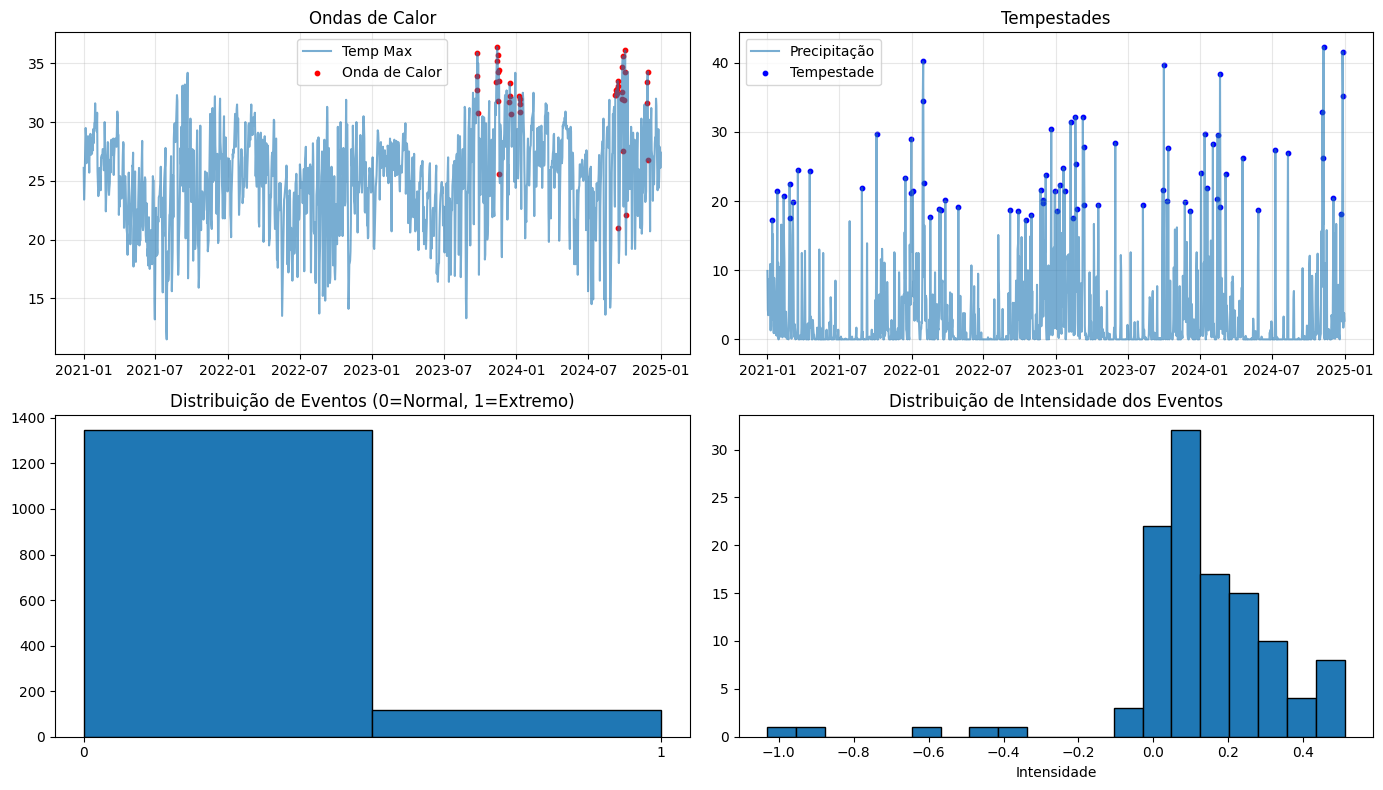

In [14]:
def detect_extreme_events(df, window=3):
    """
    Detecta eventos climáticos extremos usando critérios baseados em percentis.

    Args:
        df: DataFrame com dados climáticos
        window: Número de dias consecutivos para definir onda de calor

    Retorna:
        DataFrame com colunas de eventos adicionadas
    """
    # Calcular percentis (P95 = valores extremos)
    p95_temp = df['temp_max'].quantile(0.95)
    p95_precip = df['precipitation'].quantile(0.95)

    print(f"\n  Limites de eventos extremos:")
    print(f"  • Onda de calor: Temperatura > {p95_temp:.1f}°C por {window}+ dias")
    print(f"  • Geada: Temperatura < 2°C")
    print(f"  • Tempestade: Precipitação > {p95_precip:.1f}mm")

    # Detectar ondas de calor (temperatura alta sustentada)
    df['is_hot'] = (df['temp_max'] > p95_temp).astype(int)
    df['heatwave'] = 0

    hot_streak = 0
    for i in range(len(df)):
        if df.loc[i, 'is_hot'] == 1:
            hot_streak += 1
            if hot_streak >= window:
                df.loc[i-window+1:i+1, 'heatwave'] = 1
        else:
            hot_streak = 0

    # Detectar geadas
    df['frost'] = (df['temp_min'] < 2).astype(int)

    # Detectar tempestades
    df['storm'] = (df['precipitation'] > p95_precip).astype(int)

    # EVENTO EXTREMO GERAL (target para classificação)
    df['extreme_event'] = ((df['heatwave'] == 1) |
                           (df['frost'] == 1) |
                           (df['storm'] == 1)).astype(int)

    # Intensidade do evento (target para regressão)
    df['event_intensity'] = 0.0
    df.loc[df['heatwave'] == 1, 'event_intensity'] = \
        (df.loc[df['heatwave'] == 1, 'temp_max'] - p95_temp) / 10
    df.loc[df['frost'] == 1, 'event_intensity'] = \
        np.maximum(df.loc[df['frost'] == 1, 'event_intensity'],
                   (2 - df.loc[df['frost'] == 1, 'temp_min']) / 5)
    df.loc[df['storm'] == 1, 'event_intensity'] = \
        np.maximum(df.loc[df['storm'] == 1, 'event_intensity'],
                   (df.loc[df['storm'] == 1, 'precipitation'] - p95_precip) / 50)

    # Estatísticas dos eventos
    print(f"\nnEventos detectados:")
    print(f"  • Ondas de calor: {df['heatwave'].sum()} dias ({df['heatwave'].sum()/len(df)*100:.1f}%)")
    print(f"  • Geadas: {df['frost'].sum()} dias ({df['frost'].sum()/len(df)*100:.1f}%)")
    print(f"  • Tempestades: {df['storm'].sum()} dias ({df['storm'].sum()/len(df)*100:.1f}%)")
    print(f"  • TOTAL eventos extremos: {df['extreme_event'].sum()} dias ({df['extreme_event'].sum()/len(df)*100:.1f}%)")

    return df

# Aplicar detecção de eventos
df = detect_extreme_events(df_raw, window=3)

# Visualizar distribuição de eventos
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0,0].plot(df['date'], df['temp_max'], alpha=0.6, label='Temp Max')
axes[0,0].scatter(df[df['heatwave']==1]['date'],
                  df[df['heatwave']==1]['temp_max'],
                  color='red', s=10, label='Onda de Calor')
axes[0,0].set_title('Ondas de Calor')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(df['date'], df['precipitation'], alpha=0.6, label='Precipitação')
axes[0,1].scatter(df[df['storm']==1]['date'],
                  df[df['storm']==1]['precipitation'],
                  color='blue', s=10, label='Tempestade')
axes[0,1].set_title('Tempestades')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(df['extreme_event'], bins=2, edgecolor='black')
axes[1,0].set_title('Distribuição de Eventos (0=Normal, 1=Extremo)')
axes[1,0].set_xticks([0, 1])

axes[1,1].hist(df[df['extreme_event']==1]['event_intensity'], bins=20, edgecolor='black')
axes[1,1].set_title('Distribuição de Intensidade dos Eventos')
axes[1,1].set_xlabel('Intensidade')

plt.tight_layout()
plt.show()

## 3. Criação de Sequências Temporais

### 3.1 Janela Temporal (Window Size)

Para a classificação de séries temporais, utiliza-se uma janela deslizante:

- Entrada: 30 dias de histórico climático (10 variáveis por dia)
- Saída: indicação se ocorrerá um evento extremo nos próximos 7 dias

### 3.2 Engenharia de Features

Além das variáveis climáticas originais, foram criadas features derivadas:

- Amplitude térmica diária (temp_max - temp_min)
- Média móvel de temperatura (7 dias)
- Soma acumulada de precipitação (7 dias)

### 3.3 Normalização

Foi aplicado StandardScaler para normalizar todas as variáveis (média = 0, desvio = 1).


In [15]:
def create_sequences_with_labels(df, window_size=30, forecast_horizon=7):
    """
    Cria sequências temporais para treinamento do LSTM.

    Args:
        df: DataFrame com dados climáticos e eventos
        window_size: Tamanho da janela de entrada (30 dias)
        forecast_horizon: Horizonte de previsão (7 dias à frente)

    Retorna:
        X: Features (amostras, window_size, n_features)
        y_class: Labels de classificação (amostras,)
        y_reg: Labels de regressão (amostras,)
        scaler: Objeto StandardScaler ajustado
        feature_cols: Lista de nomes das features
    """
    # Features base
    feature_cols = ['temp_max', 'temp_min', 'temp_mean',
                    'precipitation', 'wind_speed', 'humidity', 'pressure']

    # Engenharia de features
    df['temp_range'] = df['temp_max'] - df['temp_min']
    df['temp_rolling_mean_7'] = df['temp_mean'].rolling(window=7, min_periods=1).mean()
    df['precip_rolling_sum_7'] = df['precipitation'].rolling(window=7, min_periods=1).sum()

    feature_cols.extend(['temp_range', 'temp_rolling_mean_7', 'precip_rolling_sum_7'])

    # Normalização
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X, y_class, y_reg = [], [], []

    # Criar sequências com janela deslizante
    for i in range(len(df) - window_size - forecast_horizon + 1):
        # Janela de entrada (30 dias)
        X.append(df[feature_cols].iloc[i:i+window_size].values)

        # Target: evento nos próximos 7 dias?
        future_window = df.iloc[i+window_size:i+window_size+forecast_horizon]
        has_event = future_window['extreme_event'].max()
        max_intensity = future_window['event_intensity'].max()

        y_class.append(has_event)
        y_reg.append(max_intensity)

    X = np.array(X)
    y_class = np.array(y_class)
    y_reg = np.array(y_reg)

    return X, y_class, y_reg, scaler, feature_cols

def prepare_data(df, window_size=30, forecast_horizon=7, train_ratio=0.8):
    """
    Prepara dados para treinamento com divisão temporal.
    """
    X, y_class, y_reg, scaler, feature_cols = create_sequences_with_labels(
        df, window_size, forecast_horizon
    )

    # Divisão temporal (SEM shuffle!)
    train_size = int(len(X) * train_ratio)

    X_train, X_test = X[:train_size], X[train_size:]
    y_class_train, y_class_test = y_class[:train_size], y_class[train_size:]
    y_reg_train, y_reg_test = y_reg[:train_size], y_reg[train_size:]

    print(f"\n Dados preparados:")
    print(f"  • Shape de X_train: {X_train.shape}")
    print(f"  • Shape de X_test: {X_test.shape}")
    print(f"  • Número de features: {X_train.shape[2]}")
    print(f"  • Eventos em treino: {y_class_train.sum()} ({y_class_train.sum()/len(y_class_train)*100:.1f}%)")
    print(f"  • Eventos em teste: {y_class_test.sum()} ({y_class_test.sum()/len(y_class_test)*100:.1f}%)")

    return X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test, scaler, feature_cols

# Criar sequências
WINDOW_SIZE = 30
FORECAST_HORIZON = 7

X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test, scaler, feature_cols = \
    prepare_data(df, window_size=WINDOW_SIZE, forecast_horizon=FORECAST_HORIZON)

print(f"\n Formato final dos dados:")
print(f"  • X_train: {X_train.shape} -> (amostras, timesteps, features)")
print(f"  • y_class_train: {y_class_train.shape} -> (amostras,)")



 Dados preparados:
  • Shape de X_train: (1140, 30, 10)
  • Shape de X_test: (285, 30, 10)
  • Número de features: 10
  • Eventos em treino: 363 (31.8%)
  • Eventos em teste: 95 (33.3%)

 Formato final dos dados:
  • X_train: (1140, 30, 10) -> (amostras, timesteps, features)
  • y_class_train: (1140,) -> (amostras,)


## 4. Arquitetura do Modelo LSTM com Attention

### 4.1 Mecanismo de Atenção (Attention Mechanism)

O mecanismo de atenção permite que o modelo identifique quais timesteps da janela de 30 dias são mais relevantes para a classificação. Ele atribui pesos de atenção a cada dia.

**Funcionamento:**
1. Cálculo dos scores de atenção para cada timestep
2. Aplicação de softmax para normalizar os scores
3. Ponderação dos timesteps pelos pesos de atenção
4. Geração de uma representação agregada


In [16]:
class AttentionLayer(layers.Layer):
    """
    Camada de Atenção customizada para LSTM.

    Permite que o modelo "foque" nos dias mais relevantes da janela temporal.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calcular scores de atenção
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1), a

    def get_config(self):
        return super(AttentionLayer, self).get_config()


### 4.2 Modelo Principal: LSTM Bidirecional + Attention

**Arquitetura:**

1. Input Layer: (30 timesteps, 10 features)
2. Bidirectional LSTM 1: 128 unidades (256 totais), return_sequences=True
3. Bidirectional LSTM 2: 64 unidades (128 totais), return_sequences=True
4. Attention Layer: ponderação dos timesteps mais relevantes
5. Dense Layers: 64 → 32 unidades com dropout
6. Saídas duais:
   - Classificação (sigmoid): evento extremo (sim/não)
   - Regressão (linear): intensidade do evento


In [17]:
def build_lstm_attention_model(window_size, n_features):
    """
    Constrói modelo LSTM Bidirecional com Attention e saída dual.
    """
    inputs = Input(shape=(window_size, n_features), name='input_sequence')

    # LSTM Bidirecional Layer 1
    lstm1 = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.2),
        name='bidirectional_lstm_1'
    )(inputs)

    # LSTM Bidirecional Layer 2
    lstm2 = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.2),
        name='bidirectional_lstm_2'
    )(lstm1)

    # Attention Layer
    attention_output, attention_weights = AttentionLayer(name='attention')(lstm2)

    # Camadas densas compartilhadas
    dense1 = layers.Dense(64, activation='relu', name='shared_dense_1')(attention_output)
    dense1 = layers.Dropout(0.3)(dense1)
    dense2 = layers.Dense(32, activation='relu', name='shared_dense_2')(dense1)

    # Saída 1: Classificação binária
    classification_output = layers.Dense(1, activation='sigmoid', name='classification')(dense2)

    # Saída 2: Regressão de intensidade
    regression_output = layers.Dense(1, activation='linear', name='regression')(dense2)

    # Modelo com múltiplas saídas
    model = Model(
        inputs=inputs,
        outputs=[classification_output, regression_output],
        name='LSTM_Attention_Climate'
    )

    # Compilação com perdas diferentes
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'classification': 'binary_crossentropy',
            'regression': 'mse'
        },
        loss_weights={
            'classification': 1.0,
            'regression': 0.5
        },
        metrics={
            'classification': ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()],
            'regression': ['mae']
        }
    )

    return model

# Construir modelo
n_features = X_train.shape[2]
model_attention = build_lstm_attention_model(WINDOW_SIZE, n_features)

print("\n  Arquitetura do Modelo LSTM + Attention:")
model_attention.summary()



  Arquitetura do Modelo LSTM + Attention:


Model: "LSTM_Attention_Climate"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 30, 256)   │    142,336 │ input_sequence[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 30, 128)   │    164,352 │ bidirectional_ls… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, 128),     │     16,512 │ bidirectional_ls… │
│ (AttentionLayer)    │ (None, 30, 128)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_1      │ (None, 64)        │      8,256 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ shared_dense_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_2      │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ shared_dense_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         33 │ shared_dense_2[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,602 (1.27 MB)

 Trainable params: 333,602 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

---

### 4.3 Modelo Baseline (para comparação)

Implementou-se um modelo LSTM simples, sem mecanismo de atenção, com o objetivo de comparar seu desempenho com o modelo principal e avaliar o impacto do uso de Attention.


In [18]:
def build_baseline_lstm(window_size, n_features):
    """
    Modelo LSTM simples sem Attention (baseline).
    """
    inputs = Input(shape=(window_size, n_features))
    lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.2)(inputs)
    lstm2 = layers.LSTM(64, dropout=0.2)(lstm1)
    dense = layers.Dense(32, activation='relu')(lstm2)

    classification_output = layers.Dense(1, activation='sigmoid', name='classification')(dense)
    regression_output = layers.Dense(1, activation='linear', name='regression')(dense)

    model = Model(inputs=inputs, outputs=[classification_output, regression_output])

    model.compile(
        optimizer='adam',
        loss={'classification': 'binary_crossentropy', 'regression': 'mse'},
        loss_weights={'classification': 1.0, 'regression': 0.5},
        metrics={'classification': ['accuracy'], 'regression': ['mae']}
    )

    return model

model_baseline = build_baseline_lstm(WINDOW_SIZE, n_features)

print("\n  Arquitetura do Modelo Baseline:")
model_baseline.summary()


  Arquitetura do Modelo Baseline:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 30, 128)   │     71,168 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     49,408 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,722 (479.38 KB)

 Trainable params: 122,722 (479.38 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Treinamento dos Modelos

### 5.1 Callbacks

Foram utilizados callbacks para otimizar o processo de treinamento:

- EarlyStopping: interrompe o treinamento quando a loss de validação não melhora por 15 épocas
- ReduceLROnPlateau: reduz a taxa de aprendizado quando a loss estagna
- ModelCheckpoint: salva o melhor modelo durante o treinamento


In [20]:
def train_model(model, X_train, y_class_train, y_reg_train,
                X_test, y_class_test, y_reg_test,
                model_name='lstm', epochs=100, batch_size=32):
    """
    Treina modelo com callbacks.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_classification_loss',
            patience=15,
            restore_best_weights=True,
            mode='min', # Added 'mode' parameter
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_classification_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_classification_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    print(f"\n{'='*70}")
    print(f" Treinando: {model_name}")
    print(f"{'='*70}")

    history = model.fit(
        X_train,
        {'classification': y_class_train, 'regression': y_reg_train},
        validation_data=(
            X_test,
            {'classification': y_class_test, 'regression': y_reg_test}
        ),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Treinar modelo com Attention
print("\n TREINAMENTO DO MODELO LSTM + ATTENTION")
history_attention = train_model(
    model_attention, X_train, y_class_train, y_reg_train,
    X_test, y_class_test, y_reg_test,
    model_name='lstm_attention', epochs=50, batch_size=32
)

# Treinar modelo Baseline
print("\n TREINAMENTO DO MODELO BASELINE")
history_baseline = train_model(
    model_baseline, X_train, y_class_train, y_reg_train,
    X_test, y_class_test, y_reg_test,
    model_name='lstm_baseline', epochs=50, batch_size=32
)


 TREINAMENTO DO MODELO LSTM + ATTENTION

 Treinando: lstm_attention
Epoch 1/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - classification_accuracy: 0.7080 - classification_loss: 0.5155 - classification_precision_1: 0.6142 - classification_recall_1: 0.2572 - loss: 0.5282 - regression_loss: 0.0254 - regression_mae: 0.1263
Epoch 1: val_classification_loss improved from inf to 0.68340, saving model to best_lstm_attention.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - classification_accuracy: 0.7086 - classification_loss: 0.5154 - classification_precision_1: 0.6151 - classification_recall_1: 0.2583 - loss: 0.5280 - regression_loss: 0.0253 - regression_mae: 0.1261 - val_classification_accuracy: 0.6281 - val_classification_loss: 0.6834 - val_classification_precision_1: 0.4353 - val_classification_recall_1: 0.3895 - val_loss: 0.7047 - val_regression_loss: 0.0428 - val_regression_mae: 0.1606 - learning_rate: 1.2500e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - classification_accurac

## 6. Avaliação e Resultados

### 6.1 Métricas de Classificação

A avaliação dos modelos foi realizada utilizando métricas padrão de classificação:

- **Accuracy**: proporção total de acertos
- **Precision**: proporção de predições positivas corretas
- **Recall**: proporção de eventos extremos corretamente identificados
- **F1-Score**: média harmônica entre precision e recall


In [21]:
def evaluate_model(model, X_test, y_class_test, y_reg_test, model_name='LSTM'):
    """
    Avalia modelo em conjunto de teste.
    """
    y_class_pred, y_reg_pred = model.predict(X_test, verbose=0)
    y_class_pred_binary = (y_class_pred > 0.5).astype(int).flatten()

    print(f"\n{'='*70}")
    print(f" AVALIAÇÃO: {model_name}")
    print(f"{'='*70}")

    print("\n[CLASSIFICAÇÃO - Detecção de Eventos Extremos]")
    print(classification_report(y_class_test, y_class_pred_binary,
                                target_names=['Normal', 'Evento Extremo']))

    print("\n[REGRESSÃO - Intensidade do Evento]")
    mask = y_class_test == 1
    if mask.sum() > 0:
        mae = mean_absolute_error(y_reg_test[mask], y_reg_pred[mask])
        rmse = np.sqrt(mean_squared_error(y_reg_test[mask], y_reg_pred[mask]))
        r2 = r2_score(y_reg_test[mask], y_reg_pred[mask])
        print(f"  • MAE (intensidade): {mae:.4f}")
        print(f"  • RMSE (intensidade): {rmse:.4f}")
        print(f"  • R² Score: {r2:.4f}")
    else:
        print("  • Sem eventos no conjunto de teste")

    return y_class_pred_binary, y_reg_pred, y_class_pred # Return probabilities as well

# Avaliar modelo com Attention
y_class_pred_attention_binary, y_reg_pred_attention, y_class_pred_attention_prob = evaluate_model(
    model_attention, X_test, y_class_test, y_reg_test,
    model_name='LSTM + Attention'
)

# Avaliar modelo Baseline
y_class_pred_baseline_binary, y_reg_pred_baseline, y_class_pred_baseline_prob = evaluate_model(
    model_baseline, X_test, y_class_test, y_reg_test,
    model_name='LSTM Baseline'
)


 AVALIAÇÃO: LSTM + Attention

[CLASSIFICAÇÃO - Detecção de Eventos Extremos]
                precision    recall  f1-score   support

        Normal       0.71      0.75      0.73       190
Evento Extremo       0.44      0.39      0.41        95

      accuracy                           0.63       285
     macro avg       0.57      0.57      0.57       285
  weighted avg       0.62      0.63      0.62       285


[REGRESSÃO - Intensidade do Evento]
  • MAE (intensidade): 0.1784
  • RMSE (intensidade): 0.2298
  • R² Score: -0.9675

 AVALIAÇÃO: LSTM Baseline

[CLASSIFICAÇÃO - Detecção de Eventos Extremos]
                precision    recall  f1-score   support

        Normal       0.66      0.63      0.64       190
Evento Extremo       0.33      0.37      0.35        95

      accuracy                           0.54       285
     macro avg       0.50      0.50      0.50       285
  weighted avg       0.55      0.54      0.55       285


[REGRESSÃO - Intensidade do Evento]
  • MAE (int

### 6.2 Comparação Quantitativa entre Modelos

A comparação entre o modelo LSTM com Attention e o modelo baseline (LSTM simples) foi realizada utilizando o conjunto de teste, considerando as métricas de classificação. Essa análise permite verificar o ganho de desempenho proporcion


In [23]:
def compare_models(y_class_test, y_class_pred_attention_binary, y_class_pred_baseline_binary):
    """
    Compara performance entre modelo com Attention e Baseline.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"\n{'='*70}")
    print(" COMPARAÇÃO DE MODELOS")
    print(f"{'='*70}")

    # Métricas Attention
    acc_att = accuracy_score(y_class_test, y_class_pred_attention_binary)
    prec_att = precision_score(y_class_test, y_class_pred_attention_binary, zero_division=0)
    rec_att = recall_score(y_class_test, y_class_pred_attention_binary, zero_division=0)
    f1_att = f1_score(y_class_test, y_class_pred_attention_binary, zero_division=0)

    # Métricas Baseline
    acc_base = accuracy_score(y_class_test, y_class_pred_baseline_binary)
    prec_base = precision_score(y_class_test, y_class_pred_baseline_binary, zero_division=0)
    rec_base = recall_score(y_class_test, y_class_pred_baseline_binary, zero_division=0)
    f1_base = f1_score(y_class_test, y_class_pred_baseline_binary, zero_division=0)

    # Tabela comparativa
    comparison = pd.DataFrame({
        'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'LSTM + Attention': [acc_att, prec_att, rec_att, f1_att],
        'LSTM Baseline': [acc_base, prec_base, rec_base, f1_base],
        'Melhora (%)': [
            (acc_att - acc_base) / acc_base * 100 if acc_base > 0 else 0,
            (prec_att - prec_base) / prec_base * 100 if prec_base > 0 else 0,
            (rec_att - rec_base) / rec_base * 100 if rec_base > 0 else 0,
            (f1_att - f1_base) / f1_base * 100 if f1_base > 0 else 0
        ]
    })

    print("\n" + comparison.to_string(index=False))

    if f1_att > f1_base:
        print(f"\n Modelo com Attention é superior!")
        print(f"   Melhora de {(f1_att - f1_base) / f1_base * 100:.1f}% no F1-Score")
    else:
        print(f"\n Modelo Baseline é superior")

compare_models(y_class_test, y_class_pred_attention_binary, y_class_pred_baseline_binary)


 COMPARAÇÃO DE MODELOS

  Métrica  LSTM + Attention  LSTM Baseline  Melhora (%)
 Accuracy          0.628070       0.540351    16.233766
Precision          0.435294       0.330189    31.831933
   Recall          0.389474       0.368421     5.714286
 F1-Score          0.411111       0.348259    18.047619

 Modelo com Attention é superior!
   Melhora de 18.0% no F1-Score


## 7. Visualizações dos Resultados

### 7.1 Curvas de Treinamento e Matriz de Confusão

As visualizações incluem:

- Curvas de loss e métricas de treinamento/validação ao longo das épocas
- Matriz de confusão para avaliar o desempenho do modelo na detecção de eventos extremos



 Visualizações salvas em 'resultados_eventos_extremos.png'


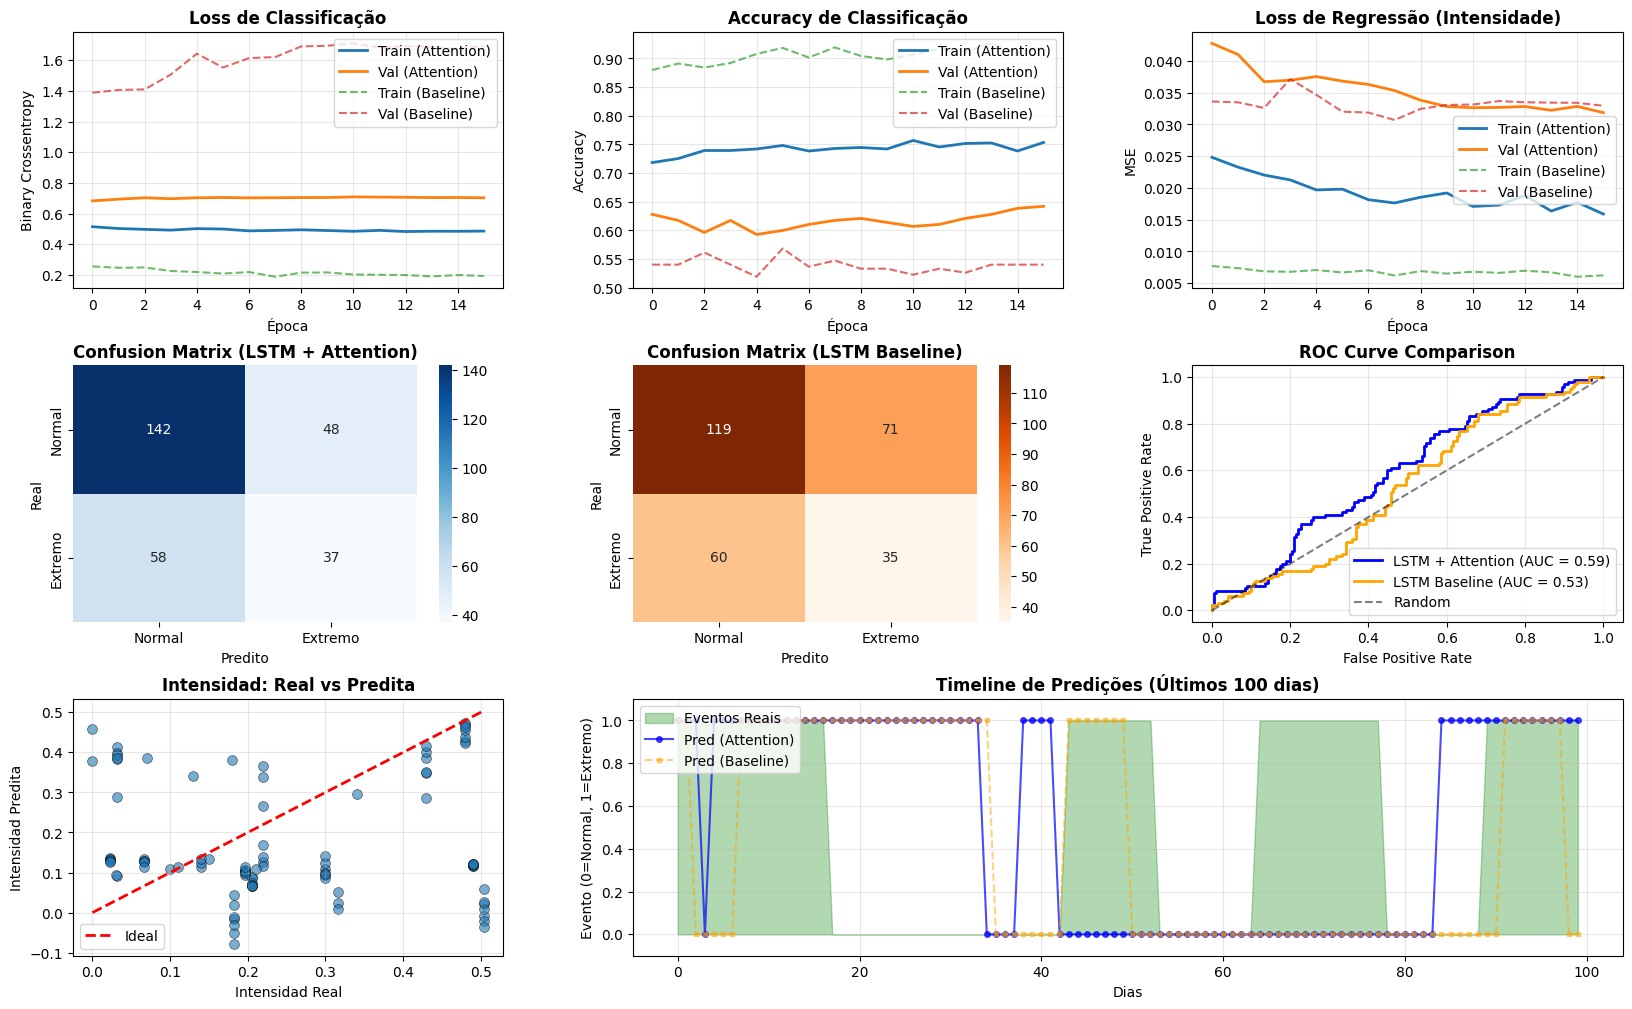

In [24]:
def plot_comprehensive_results(history_attention, history_baseline,
                                y_class_test, y_class_pred_attention_binary, y_class_pred_baseline_binary,
                                y_reg_test, y_reg_pred_attention,
                                y_class_pred_attention_prob, y_class_pred_baseline_prob):
    """
    Gera visualizações completas dos resultados.
    """
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Loss de Classificação
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history_attention.history['classification_loss'], label='Train (Attention)', linewidth=2)
    ax1.plot(history_attention.history['val_classification_loss'], label='Val (Attention)', linewidth=2)
    ax1.plot(history_baseline.history['classification_loss'], '--', label='Train (Baseline)', alpha=0.7)
    ax1.plot(history_baseline.history['val_classification_loss'], '--', label='Val (Baseline)', alpha=0.7)
    ax1.set_title('Loss de Classificação', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history_attention.history['classification_accuracy'], label='Train (Attention)', linewidth=2)
    ax2.plot(history_attention.history['val_classification_accuracy'], label='Val (Attention)', linewidth=2)
    ax2.plot(history_baseline.history['classification_accuracy'], '--', label='Train (Baseline)', alpha=0.7)
    ax2.plot(history_baseline.history['val_classification_accuracy'], '--', label='Val (Baseline)', alpha=0.7)
    ax2.set_title('Accuracy de Classificação', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Loss de Regressão
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(history_attention.history['regression_loss'], label='Train (Attention)', linewidth=2)
    ax3.plot(history_attention.history['val_regression_loss'], label='Val (Attention)', linewidth=2)
    ax3.plot(history_baseline.history['regression_loss'], '--', label='Train (Baseline)', alpha=0.7)
    ax3.plot(history_baseline.history['val_regression_loss'], '--', label='Val (Baseline)', alpha=0.7)
    ax3.set_title('Loss de Regressão (Intensidade)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('MSE')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Confusion Matrix - Attention
    ax4 = fig.add_subplot(gs[1, 0])
    cm_attention = confusion_matrix(y_class_test, y_class_pred_attention_binary)
    sns.heatmap(cm_attention, annot=True, fmt='d', cmap='Blues', ax=ax4,
                xticklabels=['Normal', 'Extremo'],
                yticklabels=['Normal', 'Extremo'])
    ax4.set_title('Confusion Matrix (LSTM + Attention)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Real')
    ax4.set_xlabel('Predito')

    # 5. Confusion Matrix - Baseline
    ax5 = fig.add_subplot(gs[1, 1])
    cm_baseline = confusion_matrix(y_class_test, y_class_pred_baseline_binary)
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Oranges', ax=ax5,
                xticklabels=['Normal', 'Extremo'],
                yticklabels=['Normal', 'Extremo'])
    ax5.set_title('Confusion Matrix (LSTM Baseline)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Real')
    ax5.set_xlabel('Predito')

    # 6. ROC Curve
    ax6 = fig.add_subplot(gs[1, 2])
    # Calcular predicciones de probabilidad para ambos modelos
    fpr_att, tpr_att, _ = roc_curve(y_class_test, y_class_pred_attention_prob)
    roc_auc_att = auc(fpr_att, tpr_att)
    fpr_base, tpr_base, _ = roc_curve(y_class_test, y_class_pred_baseline_prob)
    roc_auc_base = auc(fpr_base, tpr_base)

    ax6.plot(fpr_att, tpr_att, color='blue', lw=2, label=f'LSTM + Attention (AUC = {roc_auc_att:.2f})')
    ax6.plot(fpr_base, tpr_base, color='orange', lw=2, label=f'LSTM Baseline (AUC = {roc_auc_base:.2f})')
    ax6.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    ax6.set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
    ax6.set_xlabel('False Positive Rate')
    ax6.set_ylabel('True Positive Rate')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Scatter: Intensidad Real vs Predita
    ax7 = fig.add_subplot(gs[2, 0])
    mask = y_class_test == 1
    if mask.sum() > 0:
        ax7.scatter(y_reg_test[mask], y_reg_pred_attention[mask].flatten(),
                   alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
        max_val = max(y_reg_test[mask].max(), y_reg_pred_attention[mask].max())
        ax7.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Ideal')
        ax7.set_title('Intensidad: Real vs Predita', fontsize=12, fontweight='bold')
        ax7.set_xlabel('Intensidad Real')
    ax7.set_ylabel('Intensidad Predita')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # 8. Timeline de Predições
    ax8 = fig.add_subplot(gs[2, 1:])
    n_show = min(100, len(y_class_test))
    x_range = range(n_show)

    ax8.fill_between(x_range, 0, y_class_test[-n_show:],
                     alpha=0.3, color='green', label='Eventos Reais')
    ax8.plot(x_range, y_class_pred_attention_binary[-n_show:],
            'o-', color='blue', markersize=4, label='Pred (Attention)', alpha=0.7)
    ax8.plot(x_range, y_class_pred_baseline_binary[-n_show:],
            's--', color='orange', markersize=3, label='Pred (Baseline)', alpha=0.5)

    ax8.set_title(f'Timeline de Predições (Últimos {n_show} dias)',
                 fontsize=12, fontweight='bold')
    ax8.set_xlabel('Dias')
    ax8.set_ylabel('Evento (0=Normal, 1=Extremo)')
    ax8.legend(loc='upper left')
    ax8.grid(True, alpha=0.3)
    ax8.set_ylim(-0.1, 1.1)

    plt.savefig('resultados_eventos_extremos.png', dpi=300, bbox_inches='tight')
    print("\n Visualizações salvas em 'resultados_eventos_extremos.png'")
    plt.show()

# Gerar gráficos
plot_comprehensive_results(
    history_attention, history_baseline,
    y_class_test, y_class_pred_attention_binary, y_class_pred_baseline_binary,
    y_reg_test, y_reg_pred_attention,
    y_class_pred_attention_prob, y_class_pred_baseline_prob
)

---

### 7.2 Visualização dos Pesos de Atenção

A visualização dos pesos de atenção permite identificar quais dias da janela de 30 dias tiveram maior influência na decisão do modelo, destacando os timesteps mais relevantes para a predição.



 Visualizando Pesos de Atenção:
 Heatmap de atenção salvo em 'attention_weights.png'


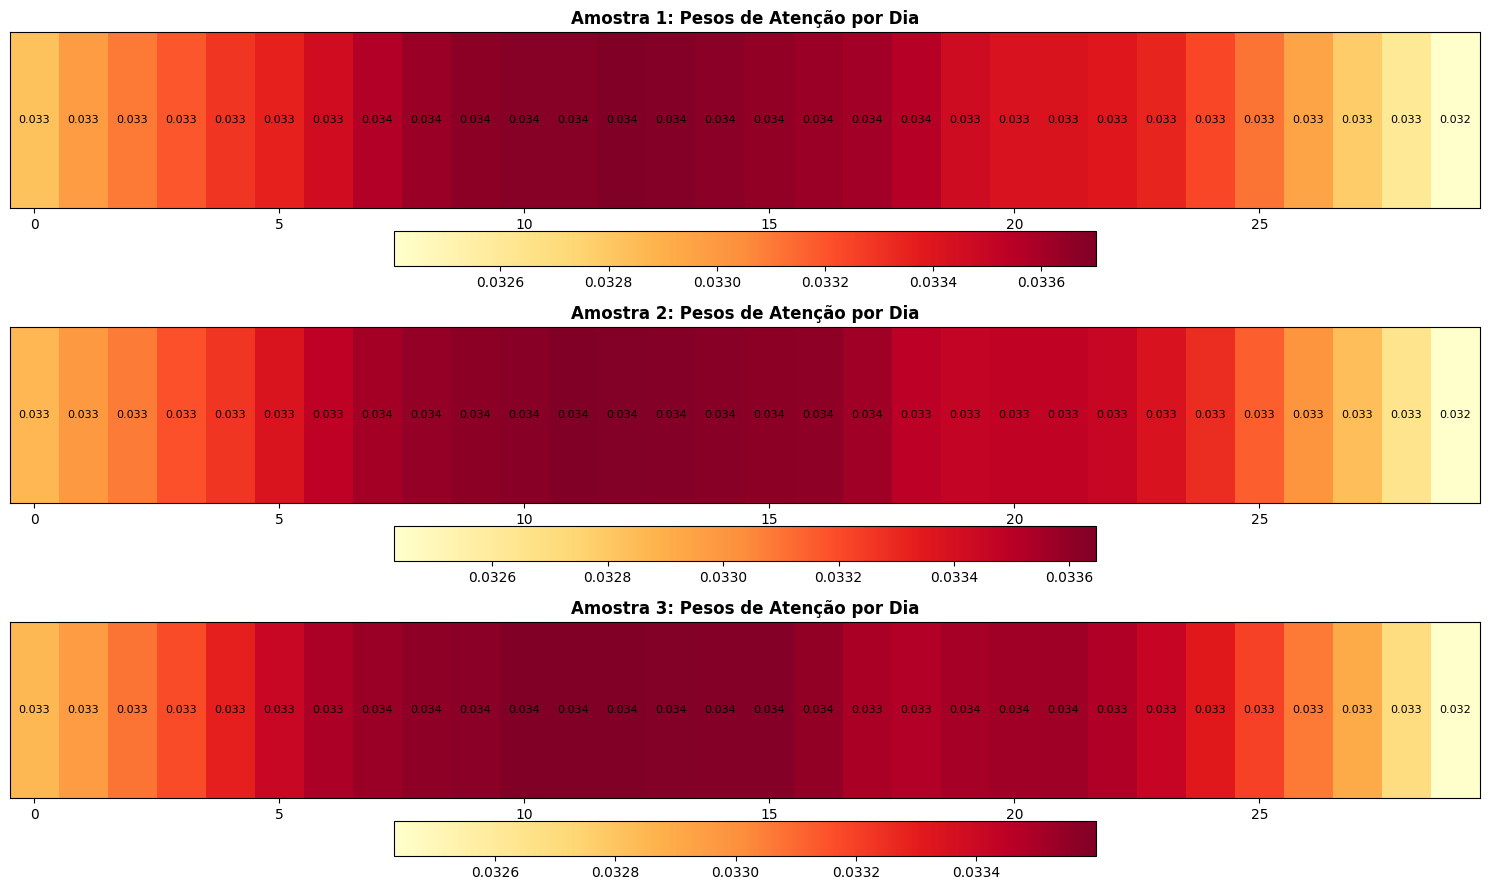

In [26]:
def plot_attention_heatmap(model, X_test, feature_names, n_samples=5):
    """
    Visualiza pesos de atenção para entender importância temporal.
    """
    try:
        # Criar modelo para extrair pesos de atenção
        attention_model = Model(
            inputs=model.input,
            outputs=model.get_layer('attention').output[1]
        )

        attention_weights = attention_model.predict(X_test[:n_samples], verbose=0)

        fig, axes = plt.subplots(n_samples, 1, figsize=(15, 3*n_samples))
        if n_samples == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            # Average attention weights across the feature dimension for each timestep
            weights = np.mean(attention_weights[i], axis=-1).squeeze()
            im = ax.imshow(weights.reshape(1, -1), cmap='YlOrRd', aspect='auto')
            ax.set_title(f'Amostra {i+1}: Pesos de Atenção por Dia',
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Dias antes da predição (0 = mais recente)')
            ax.set_yticks([])

            for j, weight in enumerate(weights):
                # Ensure weight is a scalar before formatting
                ax.text(j, 0, f'{weight:.3f}', ha='center', va='center',
                           color='black' if weight < 0.5 else 'white', fontsize=8)

            plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)

        plt.tight_layout()
        plt.savefig('attention_weights.png', dpi=300, bbox_inches='tight')
        print(" Heatmap de atenção salvo em 'attention_weights.png'")
        plt.show()

    except Exception as e:
        print(f"Erro ao gerar heatmap de atenção: {e}")

print("\n Visualizando Pesos de Atenção:")
plot_attention_heatmap(model_attention, X_test, feature_cols, n_samples=3)

## 8. Sistema de Alertas Tempranas (Aplicação Prática)

Demonstra-se como o modelo pode ser integrado a um sistema real de alertas para detecção antecipada de eventos climáticos extremos, utilizando previsões diárias para identificar possíveis riscos e emitir notificações preventivas.


In [27]:
def create_alert_system_demo(model, X_test, y_class_test, n_days=30):
    """
    Simula sistema de alertas tempranas baseado nas predições.
    """
    print(f"\n{'='*70}")
    print(" SISTEMA DE ALERTAS TEMPRANAS - DEMO")
    print(f"{'='*70}")

    y_class_pred, y_reg_pred = model.predict(X_test[-n_days:], verbose=0)

    print(f"\n Análise dos últimos {n_days} dias:\n")

    alert_count = 0
    for i in range(n_days):
        prob = y_class_pred[i][0]
        intensity = y_reg_pred[i][0]
        real = y_class_test[-n_days:][i]

        # Sistema de alertas por limiar
        if prob > 0.7:
            alert_count += 1
            status = "🔴 ALERTA VERMELHA"
            color = '\033[91m'
        elif prob > 0.5:
            status = "🟡 ALERTA AMARELA"
            color = '\033[93m'
        else:
            status = "🟢 NORMAL"
            color = '\033[92m'

        reset = '\033[0m'

        if prob > 0.5:
            print(f"{color}Dia -{n_days-i:2d}: {status} | "
                  f"Prob: {prob:.1%} | Intensidade: {intensity:.2f} | "
                  f"Real: {'SIM' if real == 1 else 'NÃO'}{reset}")

    print(f"\n Resumo:")
    print(f"  • Alertas Vermelhas emitidas: {alert_count}")
    print(f"  • Eventos reais no período: {y_class_test[-n_days:].sum()}")
    accuracy = (y_class_pred[-n_days:].flatten() > 0.5).astype(int)
    print(f"  • Taxa de acerto: {(accuracy == y_class_test[-n_days:]).sum() / n_days * 100:.1f}%")

create_alert_system_demo(model_attention, X_test, y_class_test, n_days=30)


 SISTEMA DE ALERTAS TEMPRANAS - DEMO

 Análise dos últimos 30 dias:

Dia -16: 🟡 ALERTA AMARELA | Prob: 50.7% | Intensidade: 0.12 | Real: NÃO
Dia -15: 🟡 ALERTA AMARELA | Prob: 51.3% | Intensidade: 0.12 | Real: NÃO
Dia -14: 🟡 ALERTA AMARELA | Prob: 51.0% | Intensidade: 0.13 | Real: NÃO
Dia -13: 🟡 ALERTA AMARELA | Prob: 51.0% | Intensidade: 0.13 | Real: NÃO
Dia -12: 🟡 ALERTA AMARELA | Prob: 52.2% | Intensidade: 0.13 | Real: NÃO
Dia -11: 🟡 ALERTA AMARELA | Prob: 52.1% | Intensidade: 0.14 | Real: SIM
Dia -10: 🟡 ALERTA AMARELA | Prob: 51.8% | Intensidade: 0.13 | Real: SIM
Dia - 9: 🟡 ALERTA AMARELA | Prob: 53.5% | Intensidade: 0.13 | Real: SIM
Dia - 8: 🟡 ALERTA AMARELA | Prob: 54.1% | Intensidade: 0.13 | Real: SIM
Dia - 7: 🟡 ALERTA AMARELA | Prob: 54.1% | Intensidade: 0.13 | Real: SIM
Dia - 6: 🟡 ALERTA AMARELA | Prob: 54.8% | Intensidade: 0.12 | Real: SIM
Dia - 5: 🟡 ALERTA AMARELA | Prob: 54.4% | Intensidade: 0.12 | Real: SIM
Dia - 4: 🟡 ALERTA AMARELA | Prob: 53.8% | Intensidade: 0.12 | Real

---

## 9. Análise de Erros

A análise de erros inclui a investigação de casos em que o modelo apresentou falsos positivos e falsos negativos, permitindo identificar padrões, limitações e possíveis melhorias no processo de modelagem e nos dados utilizados.


In [30]:
def analyze_errors(X_test, y_class_test, y_class_pred, n_examples=3):
    """
    Analisa casos de erro do modelo.
    """
    print(f"\n{'='*70}")
    print(" ANÁLISE DE ERROS")
    print(f"{'='*70}")

    fp_indices = np.where((y_class_pred == 1) & (y_class_test == 0))[0]
    fn_indices = np.where((y_class_pred == 0) & (y_class_test == 1))[0]

    print(f"\n Resumo de erros:")
    print(f"  • Falsos Positivos: {len(fp_indices)} casos ({len(fp_indices)/len(y_class_test)*100:.1f}%)")
    print(f"  • Falsos Negativos: {len(fn_indices)} casos ({len(fn_indices)/len(y_class_test)*100:.1f}%)")

    if len(fp_indices) > 0:
        print(f"\n Falsos Positivos (predisse evento, mas não houve):")
        for i, idx in enumerate(fp_indices[:n_examples]):
            window_data = X_test[idx]
            print(f"\n  Caso {i+1} (índice {idx}):")
            print(f"    • Temp máxima média: {window_data[:, 0].mean():.2f}")
            print(f"    • Precipitação média: {window_data[:, 3].mean():.2f}")
            print(f"    • Variância temp: {window_data[:, 0].std():.2f}")

    if len(fn_indices) > 0:
        print(f"\n Falsos Negativos (não predisse evento, mas houve):")
        for i, idx in enumerate(fn_indices[:n_examples]):
            window_data = X_test[idx]
            print(f"\n  Caso {i+1} (índice {idx}):")
            print(f"    • Temp máxima média: {window_data[:, 0].mean():.2f}")
            print(f"    • Precipitação média: {window_data[:, 3].mean():.2f}")
            print(f"    • Variância temp: {window_data[:, 0].std():.2f}")

analyze_errors(X_test, y_class_test, y_class_pred_attention_binary, n_examples=3)


 ANÁLISE DE ERROS

 Resumo de erros:
  • Falsos Positivos: 48 casos (16.8%)
  • Falsos Negativos: 58 casos (20.4%)

 Falsos Positivos (predisse evento, mas não houve):

  Caso 1 (índice 45):
    • Temp máxima média: 0.40
    • Precipitação média: -0.25
    • Variância temp: 0.53

  Caso 2 (índice 46):
    • Temp máxima média: 0.43
    • Precipitação média: -0.25
    • Variância temp: 0.55

  Caso 3 (índice 47):
    • Temp máxima média: 0.46
    • Precipitação média: -0.25
    • Variância temp: 0.56

 Falsos Negativos (não predisse evento, mas houve):

  Caso 1 (índice 26):
    • Temp máxima média: 0.47
    • Precipitação média: -0.18
    • Variância temp: 0.75

  Caso 2 (índice 27):
    • Temp máxima média: 0.48
    • Precipitação média: -0.17
    • Variância temp: 0.75

  Caso 3 (índice 28):
    • Temp máxima média: 0.44
    • Precipitação média: -0.17
    • Variância temp: 0.73
